# 0. Introduction to Facebook Prophet

<img src="Images/Prophet_image.png">
<center style="color: gray; font-style: italic">Forecasting on Peyton Manning's Wikipedia page views using Facebook Prophet.</center>
<div style="visibility:hidden">https://facebook.github.io/prophet/docs/quick_start.html</div>

### In this Notebook, you will...

1. Get familiar with what Facebook Prophet is, what it's strengths and limitations are
2. Learn how to implement a basic Prophet model on manufactured data
3. Learn how Prophet handles seasonality, and how custom seasonalities can be added
4. Learn what the Fourier order does in Prophet
5. Learn how to deploy your Prophet model, load and save it, as well as evaluate it
6. More complex problems...

Please note that in-text citations will be cited appropriately. Images will not be cited within the references; instead their links can be found by double-clicking the relevant cells, and finding the HTML tags that have links.

<div style="color:red">what about multivsriate problems? (extra regressor!)</div>

# What is Facebook Prophet?

Facebook Prophet is the industry standard for forecasting time-series data due to it's ease of use and similarity with other common data science libraries, such as sklearn [1]. It works very well with seasonal data, and is robust to missing data and outliers [2]. In fact, Prophet was designed to reduce the data science skills gap by automating time-series forecasts [3].

### What makes Prophet so powerful?

Prophet is great because it's fairly easy to get started with and it handles things such as seasonality, trends and missing data very well. For those starting their journey with time-series data analysis, Prophet is great for it provides an *easy* way to make predictions without the need for an 'expert' knowledge in either the industry where it is applied or even data science. That said though, a true expert (which hopefully you'll all be by the end of the course!) will be able to tune it's parameters to solve problems of different difficulties.

The Prophet model works best when you have data that contains **strong** seasonalities and **lots** of historical data.

# Basic implementation

For the purposes of this Module, I've tried had to find datasets other than those available on the Prophet webpage, hoping to introduce you to different problems that have different challenges. That said, where I teach in the notebooks, I'll make use of already preprocessed data... for the challenges though, you will have to process them yourself to get practising ;)

The first dataset is manufactured, it is simply a sine curve added to a linear line, plus a normal error term:
$$y_i = \sin{\left(\alpha\,t_i\right)} + t_i + Z_i$$

Where:
$$Z_i \sim \mathcal{N}\left(\mu,\sigma^2\right)$$

and:

<center>$\alpha:$ 10</center>

<center>$\mu:$ 0</center>

<center>$\sigma:$ 0.3</center>

With this in mind, we would **expect** to see a linear trend of $y=t$, since the rest of the values are oscillatory and don't increase in size, thus won't affect the trend.

In [1]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = 'Data/sine.csv' # path to data

df = pd.read_csv(path, index_col = 0)

df.head()

,ds,y
0,2015-07-01 00:00:00,0.163677
1,2015-07-02 20:38:11,-0.114845
2,2015-07-04 17:16:23,0.323911
3,2015-07-06 13:54:35,0.746910
4,2015-07-08 10:32:47,0.357809


Prophet requires the 'time' variable to be called 'ds', and the target variable to be called 'y'. The time variabe ('ds') must also be strings in a datetime format, so 'YYYY-mm-dd' or 'YYYY-mm-dd HH:MM:SS'. For the sake of this tutorial, the data is already in this format; but this is **important for when you use Prophet for other projects.**

In [3]:
model = Prophet() # instantiate Prophet model
model.fit(df)

df_future = model.make_future_dataframe(periods = 365) # create time index for future forecast (1 year)
print(df_future.shape)
df_future.tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(1365, 1)


,ds
1360,2021-07-28
1361,2021-07-29
1362,2021-07-30
1363,2021-07-31
1364,2021-08-01


The 'make_future_dataframe' function is useful, as it allows us to create forecasts with Prophet. What this does is extend the time variable ('ds') for the next X indexes , where X is defined by the user using periods = X. So in the above case, we created 365 extra points. Note that the 'df_future' includes the **initial** 'df' values too.

In [4]:
forecast = model.predict(df_future) # create forecast

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,0.031417,-0.974011,-0.041428,0.031417,0.031417,-0.564248,-0.564248,-0.564248,-0.019988,-0.019988,-0.019988,-0.544260,-0.544260,-0.544260,0.0,0.0,0.0,-0.532831
1,2015-07-02 20:38:11,0.037576,-0.937577,0.061760,0.037576,0.037576,-0.460076,-0.460076,-0.460076,0.022460,0.022460,0.022460,-0.482536,-0.482536,-0.482536,0.0,0.0,0.0,-0.422500
2,2015-07-04 17:16:23,0.043734,-0.784822,0.132679,0.043734,0.043734,-0.380149,-0.380149,-0.380149,0.039033,0.039033,0.039033,-0.419182,-0.419182,-0.419182,0.0,0.0,0.0,-0.336415
3,2015-07-06 13:54:35,0.049893,-0.833762,0.137284,0.049893,0.049893,-0.377226,-0.377226,-0.377226,-0.022215,-0.022215,-0.022215,-0.355012,-0.355012,-0.355012,0.0,0.0,0.0,-0.327333
4,2015-07-08 10:32:47,0.056052,-0.744421,0.205555,0.056052,0.056052,-0.322025,-0.322025,-0.322025,-0.031263,-0.031263,-0.031263,-0.290762,-0.290762,-0.290762,0.0,0.0,0.0,-0.265973


The above dataframe shows the components generated by the Prophet model. 'yhat' represents the predicted line. 'yhat_lower' and 'yhat_upper' represent the confidence intervals for the prediction. There are other terms such as 'trend', 'additive_terms', 'weekly' and 'multiplicative' terms that will be discussed later.

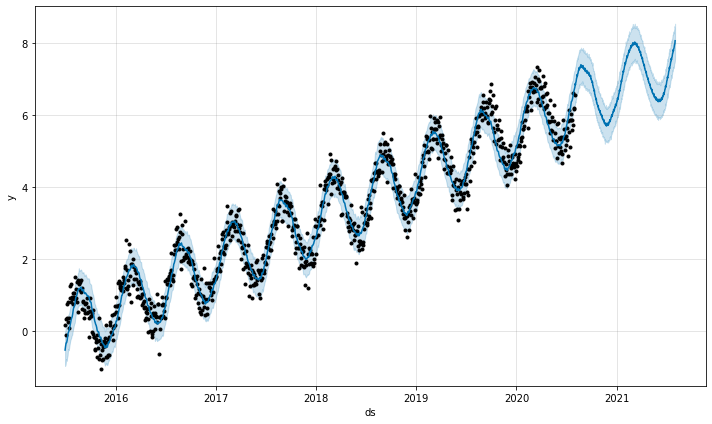

In [5]:
import matplotlib.pyplot as plt

fig_1 = model.plot(forecast) # plot the model

The black dots represent actual data points, while the blue line represents the 'yhat', and the faint blue shadowing represents the confidence intervals. Anything outside this would be considered an 'anomaly'. The individual components of the above plot can also be easily visualised using:

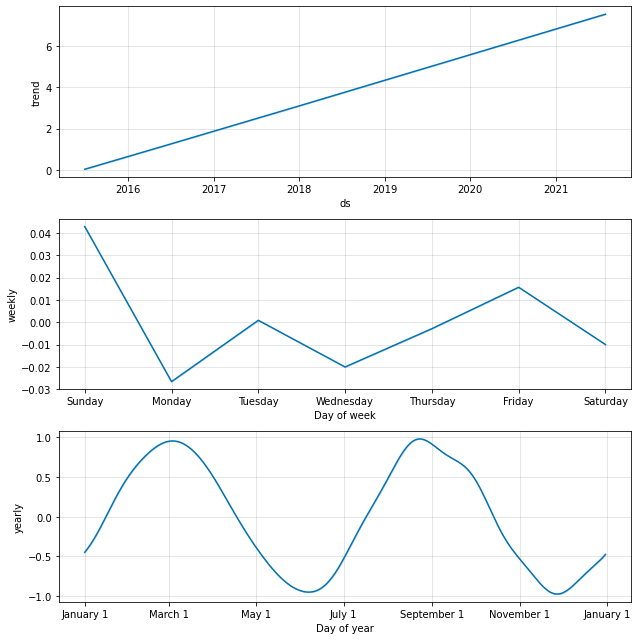

In [6]:
fig_2 = model.plot_components(forecast)

This is highly useful when exploring datasets, for it can provide you with interesting insight. In this case, we notice that the trend is as we expected, a straight line. To view how to extract the above information individually, double click this cell.

<!--

# to extract information from each plot, you must unpack the axes. The above is a matplotlib 'subplot' object.
# So:

plots = fig_2.get_axes()

# trend
x,y = plots[0].lines[0].get_data()

# weekly
x,y = plots[1].lines[0].get_data()

# yearly
x,y = plots[2].lines[0].get_data()

-->

# Seasonality

### Types of seasonality

Prophet really shines in how it allows you to control the seasonalities for the model. In the example above, this was done automatically as Prophet sets daily_seasonality, weekly_seasonality and yearly_seasnality to 'auto'. However, seasonality is more nuanced than this and may require you to manually set some options.

Recall the two different types of seasonalities:

Linear (default mode in Prophet)
$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

Example:

<img style = "width:60%" src="Images/Additive_example.png">

Where $g(t)$ is the **trend**, $s(t)$ is the periodic signals (**seasons**), $h(t)$ is the **holiday effect** (this refers to irregular occuring events that cover a certain period of time) and $\epsilon_t$ which represents **noise**.

Multiplicative:

$$y(t) = g(t) \cdot s(t) \cdot h(t) \cdot \epsilon_t$$

Example:

<img style = "width:60%" src="Images/Multiplicative_example.png">

Changing this is very simple, and can be done by setting 'seasonality_mode = "multiplicative"'

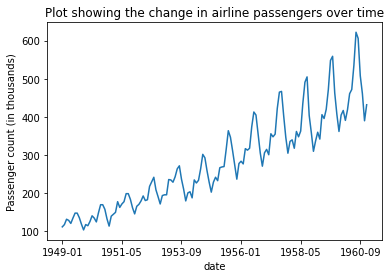

In [42]:
import numpy as np


# test on data
path = 'Data/passengers.csv'
df_multiplicative = pd.read_csv(path) 


fig = plt.figure() # examine the dataset
plt.plot(df_multiplicative.index, df_multiplicative.y)

# set xticks
xloc = np.linspace(0,140,6)
plt.xticks(xloc,labels=[df_multiplicative.ds[i] for i in xloc])

plt.title('Plot showing the change in airline passengers over time')
plt.xlabel('date')
plt.ylabel('Passenger count (in thousands)')

plt.show()

Here, even more so than the artificial sine curve shows, we can see how the model is seasonal, with the seasonality increasing multiplicatively. This makes sense, for we expect the numpy of passengers to grow over time, but we also expect sharp peaks during the high season. Let's see the effect that we get when modelling with the additive and multiplicative methods.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


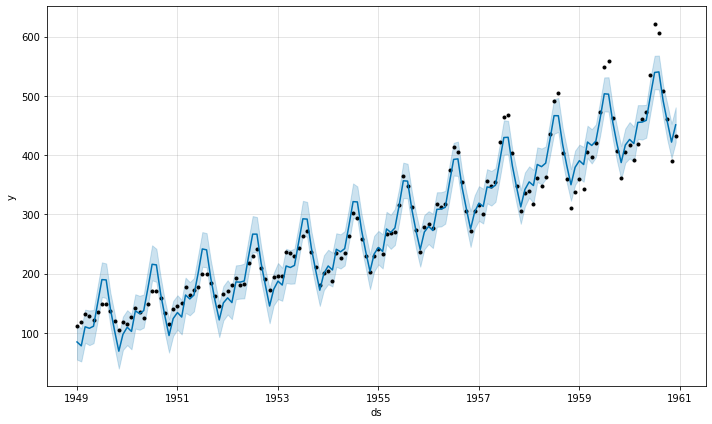

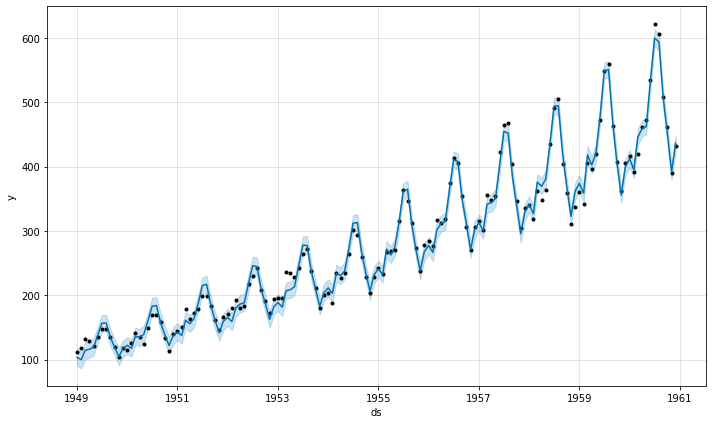

In [43]:
# instantiate objects 

m_multiplicative = Prophet(
    seasonality_mode = 'multiplicative'
)

m_additive = Prophet(
    seasonality_mode = 'additive' # set by default
)

m_additive.fit(df_multiplicative)
forecast = m_additive.predict(df_multiplicative)
fig_3 = m_additive.plot(forecast)


m_multiplicative.fit(df_multiplicative)
forecast = m_multiplicative.predict(df_multiplicative)
fig_4 = m_multiplicative.plot(forecast)

We notice two very important things from the above: 
The first model that assumed an additive seasonality was bad at fitting BOTH small values (nearer to 1949) and the larger ones.

### Holidays

In addition to different types of seasonality, Prophet allows users to set their own, custom seasonalities (i.e. quarterely seasonalities for example), or account for 'holidays'. Holidays can be quite important in analysis, because you might want to capture irregular occurances. 

For example, consider that you want to model the car usage in the UAE. Unlike in Europe, religious holidays are not fixed, since Eid (a Muslim holiday) is based on a lunar calendar, and thus moves back by 10 days every year with respect to the Gregorian calendar. In such a case, you would need to specify the dates of Eid, so that the Prophet model 'knows' that there will be spikes on those days.

But one must be careful when specifying holidays: in Europe for example, Christmas is a recurring holiday that happens on the same day, every year. As such, it would automatically get captured by the yearly seasonality. In that case, Prophet would add an extra 'holiday' effect on top of the yearly seasonality for Christmas.

Holidays must be set as a dataframe with 4 columns, 'holiday' which is what the holiday is, a 'ds' column which is the date at which the holiday occurs, 'lower_window' and 'upper_window'.

Lower and Upper window control the amount of days that the holiday lags or leads for. For example, a holiday like Christmas will always effectively act as at least two days, since there is always a day for boxing day. In this case, it would be given an 'upper_window' or 1 (i.e. the holiday lasts for 1 day after the date specified) and a 'lower_window' of 0.

Likewise, in the UAE, Eid typically lasts for 3 days, so in that case, the 'upper_window' is 2.

Let's see an example of how to set this up for Eid, from 2015 to 2020.

In [62]:
eid_al_fitr = ['2015-07-17','2016-07-06','2017-06-25',
               '2018-06-15','2019-06-05','2020-05-24'] # the first Muslim Eid, follows Ramadan directly

eid_al_adha = ['2015-09-24','2016-09-10','2017-08-31',
               '2018-08-22','2019-08-12','2020-07-31'] # the second Muslim eid

holidays = pd.DataFrame(data = {
    'holiday':'eid_al_fitr',
    'ds':eid_al_fitr
})

holidays = pd.concat([holidays, pd.DataFrame( data = {'holiday':'eid_al_adha','ds':eid_al_adha})], axis = 0)

holidays['upper_window'] = 2
holidays['lower_window'] = 0

holidays

,holiday,ds,upper_window,lower_window
0,eid_al_fitr,2015-07-17,2,0
1,eid_al_fitr,2016-07-06,2,0
2,eid_al_fitr,2017-06-25,2,0
3,eid_al_fitr,2018-06-15,2,0
4,eid_al_fitr,2019-06-05,2,0
5,eid_al_fitr,2020-05-24,2,0
0,eid_al_adha,2015-09-24,2,0
1,eid_al_adha,2016-09-10,2,0
2,eid_al_adha,2017-08-31,2,0
3,eid_al_adha,2018-08-22,2,0


To instantiate a model AND include the effect of holidays, we must simply add a holidays keyword, as well as our holidays dataframe as inputs.

In [63]:
m_holidays = Prophet(holidays = holidays)

Having added the holidays, we actually get an extra 'holidays' subplot in out component plot (**recall model.plot_components(forecast)**).

I have not included a live example due to not finding good data for this problem, however, this is an annocated example of what the component plot *may* look like.

<img style = "width:50%" src="Images/holidayslabel.png">

It is in fact possible to add another column to the holidays parameter, and this is called 'prior_scale'. This parameter controls how **sensitive** your Prophet model is to those holiday effects. Larger values allow the model to behave more sharply with regards to flucturations, whereas smaller values will give a smoother (yet perhaps underfitted) fit.

### Fourier order of model

So you may be wondering how Prophet is able to (somewhat well) capture periodic (seasonal) trends?

This is because it uses a Fourier series approximation for seasonal trends:

$$
s(t) = \sum_{n=1}^N \left (
a_n\cos{
\left(
\frac{2\pi nt}{P}
\right) + b_n \sin{
\left(
\frac{2\pi nt}{P}
\right)
}
}
\right)$$

Where:

$s(t)$: the seasonal signal

$P$: period in days, so for example a yearly seasonality has $P = 365.25$

It is out of the scope of this notebook to go into detail with what Fourier series are, or how the Prophet model does this exactly, however if you are interested you can visit the following two links:

1) Fourier series: https://www.youtube.com/watch?v=r6sGWTCMz2k&list=PLZHQObOWTQDNPOjrT6KVlfJuKtYTftqH6&index=4

2) Prophet model paper: https://peerj.com/preprints/3190/

That said, for using Prophet, all you need to know is how the **order** of the Fourier fit affects the fitting of the the model. The higher the order of the model, the more likely it is that your data will be overfit.

Let's revisit the first example with the manufactured sign wave. 

<img style = "width:50%" src="Images/fourier100.png">
<center style="color: gray; font-style: italic">Fourier order = 100, clearly an overfit</center>


<img style = "width:50%" src="Images/fourier1.png">
<center style="color: gray; font-style: italic">Fourier order = 1, clearly an underfit</center>


<img style = "width:50%" src="Images/fourier2.png">
<center style="color: gray; font-style: italic">Fourier order = 2, seems like a good fit</center>

We can clearly see that the the order of the fit affects the smoothness of the fit. You may be wondering why an increase from Fourier order 1 to 2 has caused such a massive difference. That's because there is another factor that affects the smoothness of the fit, which the 'prior_scale' discussed in the holidays section above.

Before, we mentioned that the 'prior_scale' defines how sensitive the model is to holiday effects. However, in the context of seasonality, 'prior_scale' affects how sensitive the model is to seasonality. Once again, the higher the prior_scale, the more sensitive the model is to seasonality. However, this effect is not exactly the same as the Fourier order effect.

Consider the two following examples, both fitted with a fourier order of 100, but with different prior_scale values.

<img style = "width:50%" src="Images/prior_large_fcst.png">
<center style="color: gray; font-style: italic">Fourier order = 100, prior_scale = 0.01</center>


<img style = "width:50%" src="Images/prior_large_fcst.png">
<center style="color: gray; font-style: italic">Fourier order = 100, prior_scale = 1000</center>

We can see that the above two graphs are almost identical... however, on close inspection we notice something interesting, in particular when we plot the components distributions.


<img style = "width:80%" src="Images/both_scales.png">
<center style="color: gray; font-style: italic">Fourier order = 100 for both</center>

We can see that the prior_scale has had no effect on the general trend, or the yearly seasonality, but it has completely changed the way that the weekly seasonalities are interpreted.

# Other parameters

The above leads us to good practices when creating Prophet models.

You're now learnt that different parameters such as the fourier order, or the prior_scale affect the way that the model is built. That said, during **Basic Implementation**, you instantiated the Prophet models very simply with: model = Prophet(), so how can you add specific features to your Prophet models?

To explain this, I will introduce you to what happens when you call the Prophet model.

Within the code, Prophet looks something like this:

In [70]:
def Prophet(growth='linear',
            changepoints=None, n_changepoints=25, changepoint_range=0.8,
            yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto',
            holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0,
            holidays_prior_scale=10.0, changepoint_prior_scale=0.05,
            mcmc_samples=0, interval_width=0.80,
            uncertainty_samples=1000, stan_backend=None
           ):
    """
    other prophet function
    """
    pass

In fact, the above is not entirely true because Prophet is actually a **class**, and not a function, however this is just for visual purposes only.

You can see that you've accessed some of the features already:
You've set holidays = holidays previously, and also changed the seasonlity_mode = 'multiplicative'.

We will now explore some of the other features.

- yearly_seasonality, weekly_seasonality and daily_seasonality are set to 'automatic', which means that Prophet figures out what Fourier order to use
- There are two prior_scale values, one for holidays and one for seasonality
- The rest of Prophet's attributes are out of the scope of this course, you may wish to read more about them here: https://github.com/facebook/prophet/blob/master/python/fbprophet/forecaster.py

With regards to the seasonality options, you can set them to either **True**,**False** or to a Fourier order.
With regards to the prior_scales, this function allows you to set a single prior scale for the entire model (this prior scale, whether it's holidays_pior_scale or seasonality_prior_scale, will affect all the holidays / seasonality respectively. Recall that when we learnt about holidays, it was possible to set the prior_scale values individually by adding a column called 'prior' scale).

I now want you to spend a couple of minutes experimenting with these Prophet options, to see the impact that they have on models.

When you play with them, I want you to keep the following in mind:

1. How are the parameters affecting the model? (are they making the model rougher or smoother? are they completely changing the type of the fit? are they changing the size of the confidence intervals?)
2. Don't just play with the parameters that I mentioned, I encouraged you to also look into what changepoints, n_changepoints, changepoint_range and growth do... that said though, prioritise seasonality and prior_scale parameters as those will be important for the next section

# Code Break

Don't have data for this :(

In [71]:
from fbprophet import Prophet

# Good Practice

Now that you are hopefully more familiar with some of the parameters, I want to introduce you to some good practice with Prophet.

Prophet has functions that allow even more functionality. We saw in the previous section that we can manually set yearly, weekly and daily seasonality, but what if we wanted something more specific? What if we want to set quarterely seasonality for example? Or biweekly seasonality? What if we were interested in setting a different prior_scale for each type of seasonality?

We can do this using the following strategy:

In [75]:
# NOTE: I'm only including parameters that we discussed in this notebook

model = Prophet(
    yearly_seasonality = False,
    weekly_seasonality = False,
    daily_seasonality = False,
    holidays = None,
    seasonality_mode = 'multiplicative'
)

# I have not set seasonality_prior_scale or holidays_prior_scale because those will be re-written by what I 
# write next

In [76]:
# now, add yearly seasonality to model

model.add_seasonality(name = 'yearly',
                      period = 365.25,
                      fourier_order = 3,
                      prior_scale = 15,
                      mode = 'additive')

Note the power in doing this. The model that was initially instantiated was set with no seasonalities (since they were all set to False) and to a multiplicative mode. I have now added my own, custom seasonality that is yearly, where I control **all of** the fourier_order of the seasonality, the prior_scale for that specific seasonality, and also it's mode.

In [77]:
# using the same method, we add our own, custom, 'quarterly'

model.add_seasonality(name = 'quarterely',
                     period = 90,
                     fourier_order = 5,
                     prior_scale = 10,
                     mode = 'additive')

# Model evaluation

# Saving and retrieving a Prophet model

In [1]:
# saving the model using pickle

# saving the model using json

# Other things that you can do with Prophet...

Due to time constraints, it was not possible to have an in depth and rigorous Prophet module. For more specific information regarding any of these topics, visit the Prophet website [2].

1. Trends
2. Conditional seasonalities

# Conclusive Remarks

Prophet is very powerful and easy to get started with. However, it's hard to get used to all of it's features and understand which ones to use. So continuous practice, as with everything, is always recommended.

It also does have weaknesses, and it's worth knowing what these are.

### Weaknesses of Prophet

Since we know Prophet's strengths, we can clearly identify weaknesses.

The greatest is perhaps the fact that Prophet requires lots of historical data. Further, one must note that for datasets that don't have a very clear seasonality, Prophet may not perform well. Prophet models also struggle with highly-skewed data.

Let's see an example of a difficult dataset:

<img style="width:60%" src="Images/Low_seasonality_data.png">
<center style="color: gray; font-style: italic">Time-series data of total gyration measured by an Arduino Nano BLE in a person's pocket.</center>

<div style="visibility:hidden"> https://github.com/namiyousef/Kin-Keepers/blob/master/Anomaly%20Detection%20in%20Significant%20Movements/Images/Ignacio_moving_average_1.png</div>

The blue dots are essentially time-series data (the orange being a moving average - don't worry about the fact that it's discontinuous as this is not relevant). As you can see from the blue dots, there is no clear seasonality. Further to this, the data collected is representative of ~ 4 days. To make matters more problematic, the data is highly high-skewed (you can see this on the graph by the proportion of points that are close to 0!). Such datasets are not suitable for Prophet. 

Another weakness of Prophet is it's functionality regarding daily seasonalities (i.e. when you have repetitive features every day); this, however, is out of the scope of this notebook.  

Now that you have an idea of what Prophet is, let's start playing!

# References

### Data sources:
1. airline-passengers.csv from https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
### Links:
1. https://facebook.github.io/prophet/docs/quick_start.html#python-api
2. https://facebook.github.io/prophet/
3. https://medium.com/future-vision/intro-to-prophet-9d5b1cbd674e